# MNIST Digit Addition Problem

Consider a task where one needs to learn a classifier $\mathtt{addition(X,Y,N)}$ where $\mathtt{X}$ and $\mathtt{Y}$ are images of digits (the MNIST data set will be used), and $\mathtt{N}$ is a natural number corresponding to the sum of these digits. The classifier should return an estimate of the validity of the addition ($0$ is invalid, $1$ is valid). 

For instance, if $\mathtt{X}$ is an image of a 0 and $\mathtt{Y}$ is an image of a 9:
- if $\mathtt{N} = 9$, then the addition is valid; 
- if $\mathtt{N} = 4$, then the addition is not valid. 

A natural approach is to seek to first 1) learn a single digit classifier, then 2) benefit from knowledge readily available about the properties of addition.
For instance, suppose that a predicate $\mathrm{digit}(x,d)$ gives the likelihood of an image $x$ being of digit $d$, one could query with LTN:    
$$
\exists d_1,d_2 : d_1+d_2= \mathtt{N} \ (\mathrm{digit}(\mathtt{X},d_1)\land \mathrm{digit}(\mathtt{Y},d_2))
$$
and use the satisfaction of this query as the output of $\mathtt{addition(X,Y,N)}$ .


The challenge is the following:
- We provide, in the data, pairs of images $\mathtt{X}$, $\mathtt{Y}$ and the result of the addition $\mathtt{N}$ (final label),
- We do **not** provide the intermediate labels, the correct digits for $d_1$, $d_2$.

Regardless, it is possible to use the equation above as background knowledge to train $\mathrm{digit}$ with LTN.
In contrast, a standard neural network baseline cannot incorporate such intermediate components as nicely.

In [1]:
import tensorflow as tf
import ltn
import baselines, data, commons
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow_datasets as tfds

import itertools


In [2]:
# Configuration
SEED = 42
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.01
POISON_RATIO = 0.1
TRIGGER_SIZE = 4
TARGET_LABEL = 1


In [3]:
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [4]:
def poison_mnist(images, labels, poison_indices, target_label, trigger_size=4):
    poisoned_images = []
    poisoned_labels = []
    original_labels = []
    is_poisoned_flags = []

    for idx in range(len(images)):
        img = images[idx]
        
        # Ensure shape is (28, 28, 1)
        if img.ndim == 2:
            img = img[:, :, np.newaxis]
        
        img = np.copy(img)
        label = labels[idx]
        is_poisoned = idx in poison_indices

        if is_poisoned:
            img[-trigger_size:, -trigger_size:, 0] = 1.0
            label = target_label

        poisoned_images.append(img)
        poisoned_labels.append(label)
        original_labels.append(labels[idx])
        is_poisoned_flags.append(is_poisoned)

    return (
        np.stack(poisoned_images).astype(np.float32),
        np.array(poisoned_labels),
        np.array(original_labels),
        np.array(is_poisoned_flags),
    )




# Training function
def train(model, train_data, labels):
    model.compile(optimizer=optimizers.SGD(learning_rate=LR),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(train_data, labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

# Evaluation
def evaluate(model, images, poisoned_labels, original_labels, is_poisoned, poisoned=False, target_label=None, title=""):
    logits = model(images, training=False)
    pred = tf.argmax(logits, axis=1).numpy()
    correct = np.sum(pred == poisoned_labels)
    total = len(poisoned_labels)
    acc = 100. * correct / total

    y_true = original_labels
    y_pred = pred

    if poisoned and target_label is not None:
        total_poisoned = np.sum(is_poisoned)
        triggered = np.sum((pred == target_label) & is_poisoned)
        attack_success = 100. * triggered / total_poisoned if total_poisoned > 0 else 0
        print(f"Attack Success Rate: {attack_success:.2f}%")
    else:
        attack_success = 0.0

    print(f"{title} Accuracy: {acc:.2f}%")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[str(i) for i in sorted(set(y_true))])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {title}")
    plt.savefig(f"{title.replace(' ', '_').lower()}_confusion_matrix.png")
    plt.close()
    return acc, attack_success


def visualize_poisoned_samples(dataset, filename="poisoned_samples_now.png", max_samples=25):
    poisoned_images = []
    poisoned_labels = []

    for img, poisoned_label, original_label, is_poisoned in dataset:
        if is_poisoned:
            poisoned_images.append(img)
            poisoned_labels.append(f"{original_label}->{poisoned_label}")
        if len(poisoned_images) >= max_samples:
            break

    if poisoned_images:
        fig, axes = plt.subplots(5, 5, figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            ax.imshow(poisoned_images[i].squeeze(), cmap='gray')
            ax.set_title(poisoned_labels[i], fontsize=8)
            ax.axis('off')
        plt.suptitle("Poisoned Samples (Original→Target)")
        plt.tight_layout()
        plt.savefig(filename)
        plt.close()
        print(f"Poisoned samples saved to {filename}")
    else:
        print("No poisoned samples found in dataset.")

## Data

Dataset of images for the digits X and Y, and their label Z s.t. X+Y=Z.

In [5]:
# ds_train, ds_test = data.get_mnist_op_dataset(
#         count_train=3000,
#         count_test=1000,
#         buffer_size=3000,
#         batch_size=16,
#         n_operands=2,
#         op=lambda args: args[0]+args[1])
# 
# # Visualize one example
# x, y, z = next(ds_train.as_numpy_iterator())
# plt.subplot(121)
# plt.imshow(x[0][:,:,0])
# plt.subplot(122)
# plt.imshow(y[0][:,:,0])
# print("Result label is %i" % z[0])

In [6]:
# import tensorflow_datasets as tfds

ds_train_old, ds_test_old = tfds.load('mnist', split=['train', 'test'], as_supervised=True, batch_size=-1)
train_images, train_labels = tfds.as_numpy(ds_train_old)
test_images, test_labels = tfds.as_numpy(ds_test_old)
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

In [7]:
n_train = len(train_images)
n_test = len(test_images)
n_poison_train = int(n_train * POISON_RATIO)
n_poison_test = int(n_test * POISON_RATIO)
poison_indices_train = np.random.choice(n_train, n_poison_train, replace=False)
poison_indices_test = np.random.choice(n_test, n_poison_test, replace=False)

X_train, Y_train, Y_train_orig, poison_flags_train = poison_mnist(train_images, train_labels, poison_indices_train, TARGET_LABEL)
X_clean, Y_clean, Y_clean_orig, _ = poison_mnist(test_images, test_labels, [], TARGET_LABEL)
X_poison, Y_poison, Y_poison_orig, poison_flags = poison_mnist(test_images, test_labels, poison_indices_test,
                                                                   TARGET_LABEL)
X_poison_full, Y_poison_full, Y_poison_orig_full, poison_flags_full = poison_mnist(test_images, test_labels, np.array(range(n_test)),
                                                                   TARGET_LABEL)

    # show_poisoned_samples(X_poison_full, Y_poison_full, count=10, filename='poisoned_samples_2.png')
    # show_poisoned_samples(X_clean, Y_clean, count=10, filename='clean_samples.png')
visualize_poisoned_samples(zip(X_poison_full, Y_poison_full, Y_poison_orig_full, poison_flags_full), filename='poisoned_samples_4.png')
visualize_poisoned_samples(zip(X_train, Y_train, Y_train_orig, poison_flags_train), filename='poisoned_samples_5.png')
    # print("it is ", X_poison_full[0][-TRIGGER_SIZE:, -TRIGGER_SIZE:, 0])
    # print("it is for clean", X_clean[0][-TRIGGER_SIZE:, -TRIGGER_SIZE:, 0])


Poisoned samples saved to poisoned_samples_4.png
Poisoned samples saved to poisoned_samples_5.png


In [8]:
# dataset = create_op_dataset(X_poison_full, Y_poison_full, poison_flags_full)

ds_train = data.create_op_dataset(X_train, Y_train, poison_flags_train,  count=3000)
ds_test = data.create_op_dataset(X_poison_full, Y_poison_full, poison_flags_full, count=1000)

ds_train_clean = data.create_op_dataset(train_images, train_labels, np.zeros(len(train_images), dtype=bool)
,  count=3000)
ds_test_clean = data.create_op_dataset(test_images, test_labels, np.zeros(len(test_images), dtype=bool)
, count=1000)
BUFFER_SIZE = 3000
BATCH_SIZE = 16

ds_train = ds_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## LTN

In [9]:
logits_model = baselines.SingleDigit(inputs_as_a_list=True)
@tf.function
def digit_softmax_wrapper(x):
    return tf.nn.softmax(logits_model(x))

class SoftmaxDigitModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def call(self, x):
        logits = self.base_model(x)
        return tf.nn.softmax(logits)

softmax_model = SoftmaxDigitModel(logits_model)

Digit = ltn.Predicate.Lambda(lambda inputs: tf.gather(
    softmax_model([inputs[0]]),  # x
    indices=tf.cast(inputs[1], tf.int32),  # d
    axis=1,
    batch_dims=1
))

d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

Notice the use of `Diag`: when grounding $x$,$y$,$n$ with three sequences of values, the $i$-th examples of each variable are matching. 
That is, `(images_x[i],images_y[i],labels[i])` is a tuple from our dataset of valid additions.
Using the diagonal quantification, LTN aggregates pairs of images and their corresponding result, rather than any combination of images and results. 
    
Notice also the guarded quantification: by quantifying only on the "intermediate labels" (not given during training) that could add up to the result label (given during training), we incorporate symbolic information into the system.

In [10]:
# mask
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])

### Axioms
@tf.function
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
    images_x = ltn.Variable("x", images_x)
    images_y = ltn.Variable("y", images_y)
    labels_z = ltn.Variable("z", labels_z)
    axiom = Forall(
            ltn.diag(images_x,images_y,labels_z),
            Exists(
                (d1,d2),
                And(Digit([images_x,d1]),Digit([images_y,d2])),
                mask=equals([add([d1,d2]), labels_z]),
                p=p_schedule
            ),
            p=2
        )
    sat = axiom.tensor
    return sat

# images_x, images_y, labels_z = next(ds_train.as_numpy_iterator())
# axioms(images_x, images_y, labels_z)

Optimizer, training steps and metrics

In [11]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
}

@tf.function
def train_step(images_x, images_y, labels_z, **parameters):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
@tf.function
def test_step(images_x, images_y, labels_z, **parameters):
    # loss
    loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))

Training

In [12]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}
for epoch in range(20,30):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(8.)}


In [13]:
history = commons.train(
    epochs=30,
    metrics_dict=metrics_dict,
    ds_train=ds_train,
    ds_test=ds_test,
    train_step=train_step,
    test_step=test_step,
    scheduled_parameters=scheduled_parameters
)

Epoch 0, train_loss: 0.9775, train_accuracy: 0.0751, test_loss: 0.8738, test_accuracy: 0.4742
Epoch 1, train_loss: 0.9487, train_accuracy: 0.2856, test_loss: 0.9806, test_accuracy: 0.0714
Epoch 2, train_loss: 0.8945, train_accuracy: 0.6326, test_loss: 0.9921, test_accuracy: 0.0258
Epoch 3, train_loss: 0.8775, train_accuracy: 0.7201, test_loss: 0.9917, test_accuracy: 0.0288
Epoch 4, train_loss: 0.7310, train_accuracy: 0.7417, test_loss: 0.9873, test_accuracy: 0.0288
Epoch 5, train_loss: 0.7189, train_accuracy: 0.7580, test_loss: 0.9872, test_accuracy: 0.0298
Epoch 6, train_loss: 0.7080, train_accuracy: 0.7793, test_loss: 0.9844, test_accuracy: 0.0347
Epoch 7, train_loss: 0.6969, train_accuracy: 0.8029, test_loss: 0.9122, test_accuracy: 0.1964
Epoch 8, train_loss: 0.4612, train_accuracy: 0.9225, test_loss: 0.2637, test_accuracy: 0.9831
Epoch 9, train_loss: 0.4259, train_accuracy: 0.9551, test_loss: 0.2465, test_accuracy: 0.9960
Epoch 10, train_loss: 0.4220, train_accuracy: 0.9561, test_l

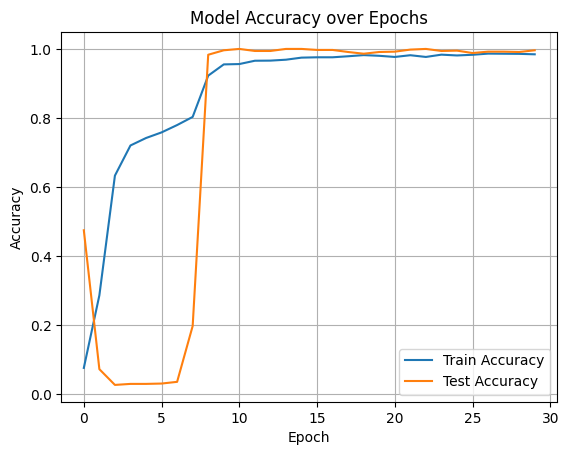

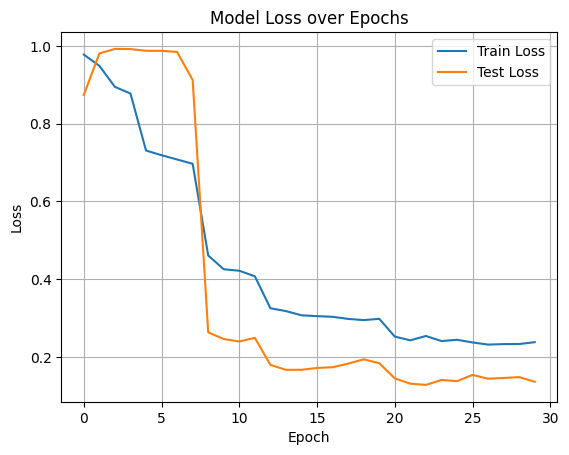

In [14]:
plt.figure()
plt.plot(range(len(history['train_accuracy'])), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(len(history['test_accuracy'])), history['test_accuracy'], label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Plot Loss
plt.figure()
plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Train Loss')
plt.plot(range(len(history['test_loss'])), history['test_loss'], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()